In [13]:
import wrds
db = wrds.Connection(wrds_username="sami_sellami")

Loading library list...
Done


Starting Week 1: Earnings Implied Volatility Data Pipeline
Fetching security information from OptionMetrics...
Retrieved 1 securities
Found securities for: <StringArray>
['AAPL']
Length: 1, dtype: string
Fetching earnings announcement dates from Compustat...
Retrieved 8 earnings announcements
Merged 8 earnings-securities records
Using 1 unique SECIDs for options data
Fetching stock prices from OptionMetrics...
Retrieved 167 stock price records
Fetching option data from OptionMetrics...
Executing options query...
Available columns in options data: ['date', 'secid', 'exdate', 'strike_price', 'cp_flag', 'best_bid', 'best_offer', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'theta', 'vega', 'volume']
Found volume column: volume
Retrieved 351292 option records
Filled 351292 missing 'underlying_price' values.

--- DEBUG: Values before moneyness calculation ---
Stats for 'strike_price':
count         351292.0
mean     166080.280792
std       66585.084207
min            30000.0
25%   

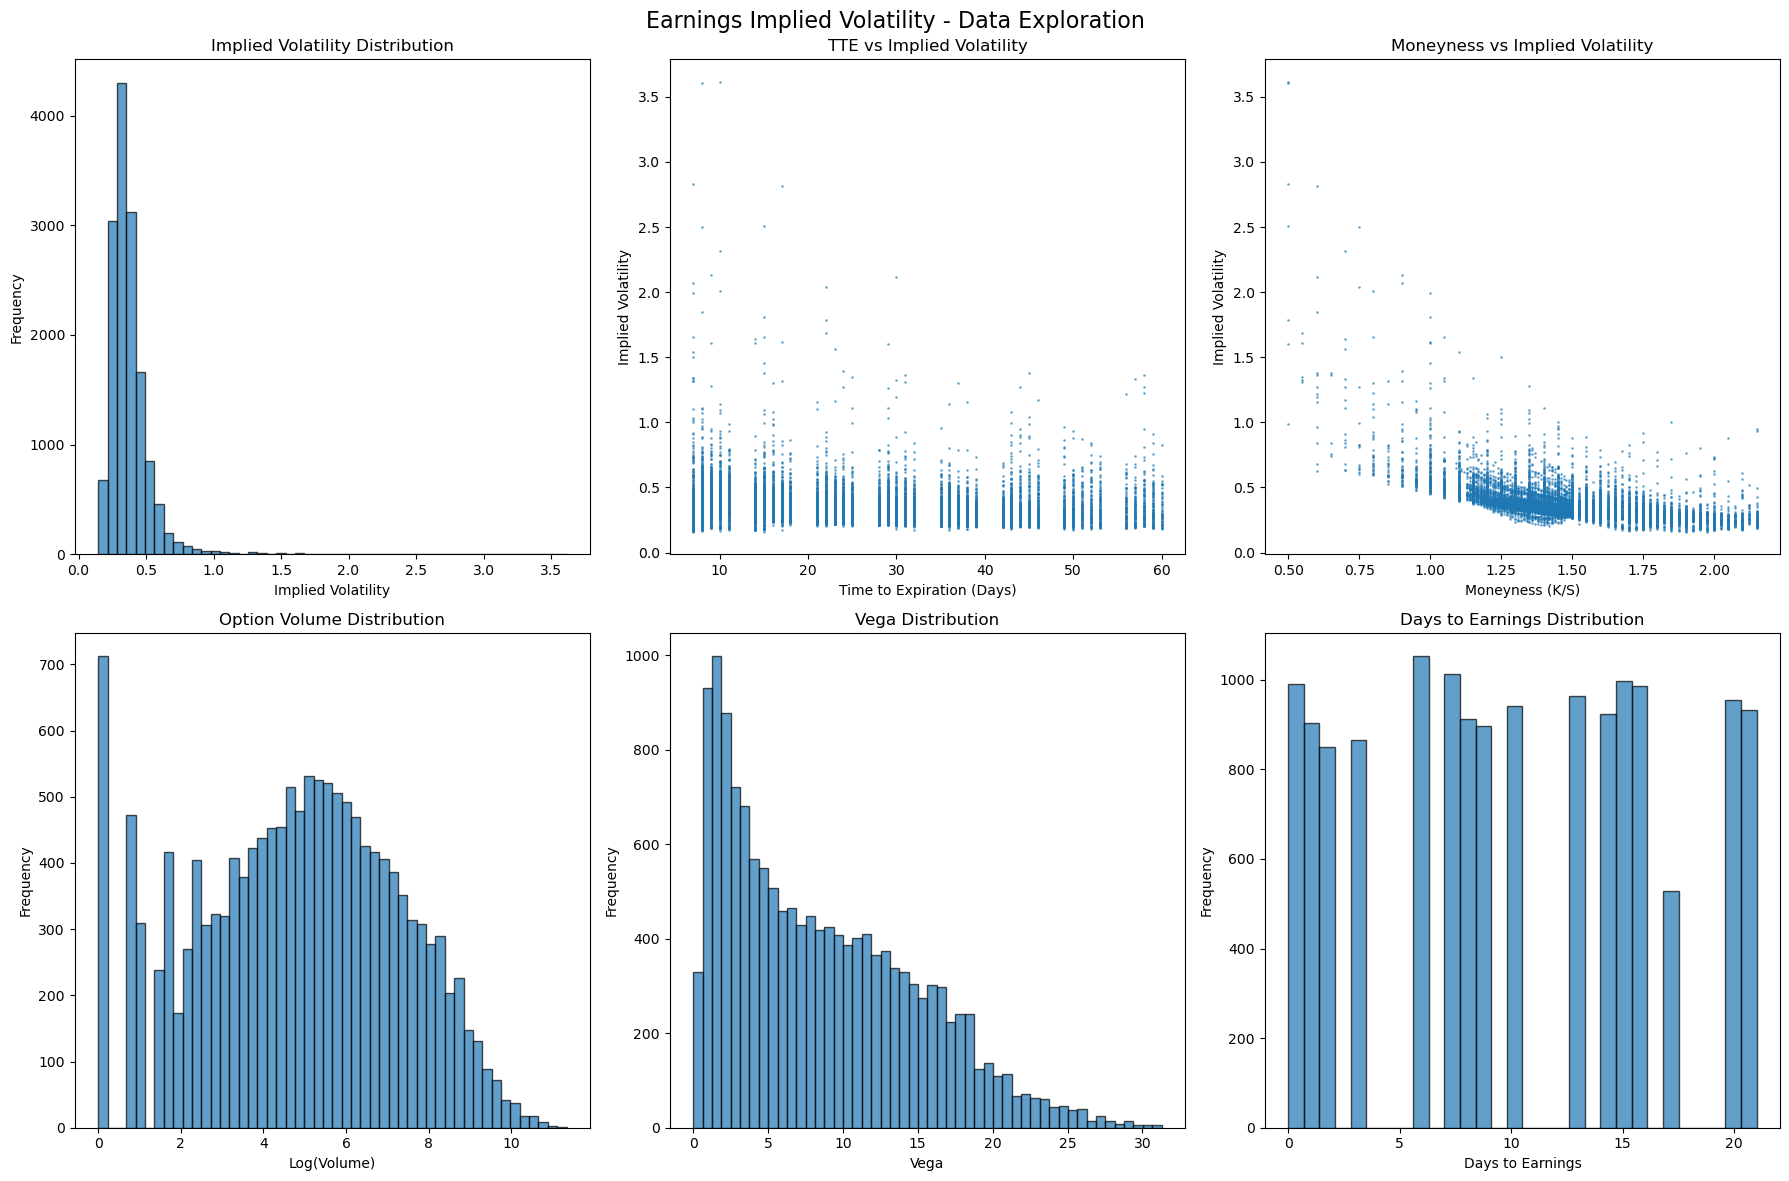


SUMMARY STATISTICS

Dataset Overview:
Total records: 14,708
Unique tickers: 1
Unique earnings dates: 3
Date range: 2023-01-12 00:00:00 to 2023-08-03 00:00:00

Implied Volatility Statistics:
count     14708.0
mean     0.373211
std      0.163195
min       0.14574
25%      0.283718
50%       0.34263
75%      0.419445
max      3.615151
Name: impl_volatility, dtype: Float64

Volume Statistics:
count        14708.0
mean     1171.413109
std      3404.693272
min              1.0
25%             20.0
50%            138.0
75%           743.25
max          84103.0
Name: volume, dtype: Float64

Vega Statistics:
count      14708.0
mean      8.495242
std       6.308816
min       0.005578
25%       2.950099
50%       7.270217
75%      12.912387
max       31.27706
Name: vega, dtype: Float64

Top 10 Tickers by Record Count:
ticker
AAPL    14708
Name: count, dtype: int64

VOLATILITY SURFACE ANALYSIS

Coverage by TTE and Moneyness:
                      impl_volatility                    volume    vega


In [48]:
"""
Earnings Implied Volatility - Week 1: Data Exploration and Pipeline (FIXED)
MFE Independent Study - UC Berkeley Haas

This script handles data collection, initial exploration, and cleaning from WRDS
for earnings implied volatility analysis using the provided query builders.

Requirements:
- WRDS account and Python library (pip install wrds)
- pandas, numpy, matplotlib, seaborn
- Access to OptionMetrics and Compustat databases
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class EarningsIVDataPipeline:
    """
    Data pipeline for earnings implied volatility analysis using WRDS data
    """
    
    def __init__(self, db_connection):
        """
        Initialize with existing WRDS connection
        
        Args:
            db_connection: Existing WRDS database connection
        """
        self.db = db_connection
        self.data = {}
        self.available_tables = None
        
    def setup_optionm_tables(self):
        """
        Get available OptionMetrics tables
        """
        if self.available_tables is None:
            tables_df = self.db.raw_sql("""
                SELECT table_name
                FROM information_schema.tables
                WHERE table_schema = 'optionm'
                ORDER BY table_name
            """)
            self.available_tables = set(tables_df['table_name'].str.lower())
        return self.available_tables
    
    def build_optionm_query(self, table_base, start_date, end_date, fields, secids=None):
        """
        Build OptionMetrics query using your existing query builder logic
        """
        table_base = table_base.lower()
        
        # Match all tables starting with the given base (e.g. opprcd)
        matching_tables = [t for t in self.available_tables if t.startswith(table_base)]
        if not matching_tables:
            return f"Table '{table_base}' not found in OptionMetrics."
        
        # SECID filter
        secid_filter = ""
        if secids is not None:
            if isinstance(secids, (list, tuple, set)):
                secid_list = ", ".join(str(s) for s in secids)
                secid_filter = f"AND secid IN ({secid_list})"
            else:
                secid_filter = f"AND secid = {secids}"
        
        # Determine year range
        years = list(range(pd.to_datetime(start_date).year, pd.to_datetime(end_date).year + 1))
        
        # Case: non-suffixed (single) table (e.g., 'securd1')
        if table_base in matching_tables:
            return f"""
    SELECT {', '.join(fields)}
    FROM optionm.{table_base}
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    {secid_filter}
            """.strip()
        
        # Case: year-suffixed tables (e.g., opprcd2014, hvold2015, etc.)
        union_queries = []
        for year in years:
            table_year = f"{table_base}{year}"
            if table_year in matching_tables:
                query = f"""
    SELECT {', '.join(fields)}
    FROM optionm.{table_year}
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    {secid_filter}
    """.strip()
                union_queries.append(query)
        
        if not union_queries:
            return f"No available year-specific tables for '{table_base}' in range {years}."
        
        return "\nUNION ALL\n".join(union_queries)
    
    def build_rdq_query_from_tickers(self, ticker_list, start_date, end_date):
        """
        Build SQL query to fetch earnings report dates (rdq) for a list of tickers.
        """
        if not ticker_list:
            raise ValueError("You must provide at least one ticker.")
        
        # Format tickers for SQL IN clause
        formatted_tickers = ', '.join([f"'{ticker}'" for ticker in ticker_list])
        
        query = f"""
        SELECT cusip,
               tic as ticker,
               datadate,
               rdq as earnings_date,
               fyearq,
               fqtr
        FROM comp.fundq
        WHERE tic IN ({formatted_tickers})
          AND rdq BETWEEN '{start_date}' AND '{end_date}'
          AND rdq IS NOT NULL
        ORDER BY tic, rdq;
        """
        return query
    
    def build_secprd_query(self, secid_list, start_date, end_date):
        """
        Build SQL query to fetch daily stock data from optionm.secprd for a list of SECIDs.
        """
        if not secid_list:
            raise ValueError("SECID list is empty.")
        
        # Format SECIDs as numeric values, no quotes
        formatted_secids = ', '.join([str(int(secid)) for secid in secid_list])
        
        query = f"""
        SELECT *
        FROM optionm.secprd
        WHERE secid IN ({formatted_secids})
          AND date BETWEEN '{start_date}' AND '{end_date}'
        ORDER BY secid, date;
        """
        return query
    
    def get_securities_info(self, ticker_list):
        """
        Get security information from OptionMetrics securd1 table
        """
        print("Fetching security information from OptionMetrics...")
        
        # Format tickers for SQL IN clause
        formatted_tickers = ', '.join([f"'{ticker}'" for ticker in ticker_list])
        
        query = f"""
        SELECT DISTINCT *
        FROM optionm.securd1
        WHERE ticker IN ({formatted_tickers})
          AND exchange_d != 0
        ORDER BY ticker
        """
        
        self.data['securities'] = self.db.raw_sql(query)
        print(f"Retrieved {len(self.data['securities'])} securities")
        
        return self.data['securities']
    
    def get_earnings_dates(self, ticker_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Fetch earnings announcement dates using Compustat
        """
        print("Fetching earnings announcement dates from Compustat...")
        
        query = self.build_rdq_query_from_tickers(ticker_list, start_date, end_date)
        
        try:
            self.data['earnings'] = self.db.raw_sql(query)
            print(f"Retrieved {len(self.data['earnings'])} earnings announcements")
            return self.data['earnings']
        except Exception as e:
            print(f"Error fetching earnings data: {e}")
            return None
    
    def get_option_data(self, secid_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Fetch option data from OptionMetrics using secids
        """
        print("Fetching option data from OptionMetrics...")
        
        # Setup available tables
        self.setup_optionm_tables()
        
        # Define fields to select - using common OptionMetrics field names
        fields = [
            'date', 'secid', 'exdate', 'strike_price', 'cp_flag',
            'best_bid', 'best_offer', 'open_interest',
            'impl_volatility', 'delta', 'gamma', 'theta', 'vega', 'volume'
        ]
        
        # Add volume field with different possible names
        volume_field_candidates = ['volume', 'vol', 'contract_volume', 'opt_volume']
        
        # Build query using your query builder
        query = self.build_optionm_query('opprcd', start_date, end_date, fields, secid_list)
        
        if "not found" in query or "No available" in query:
            print(f"Query build failed: {query}")
            return None
        
        try:
            print("Executing options query...")
            self.data['options'] = self.db.raw_sql(query)
            
            # Debug: Print column names to see what's available
            print(f"Available columns in options data: {list(self.data['options'].columns)}")
            
            # Check for volume column variations
            volume_col = None
            for col_candidate in volume_field_candidates:
                if col_candidate in self.data['options'].columns:
                    volume_col = col_candidate
                    break
            
            if volume_col:
                print(f"Found volume column: {volume_col}")
                if volume_col != 'volume':
                    self.data['options']['volume'] = self.data['options'][volume_col]
            else:
                print("No volume column found, creating synthetic volume column")
                # Create a synthetic volume column based on open interest or set to 1
                if 'open_interest' in self.data['options'].columns:
                    self.data['options']['volume'] = self.data['options']['open_interest'].fillna(1)
                else:
                    self.data['options']['volume'] = 1
            
            print(f"Retrieved {len(self.data['options'])} option records")
            return self.data['options']
        except Exception as e:
            print(f"Error fetching options data: {e}")
            print("Attempting to query with minimal fields...")
            
            # Fallback: try with minimal fields
            minimal_fields = ['date', 'secid', 'exdate', 'strike_price', 'cp_flag', 
                            'best_bid', 'best_offer', 'impl_volatility']
            
            query = self.build_optionm_query('opprcd', start_date, end_date, minimal_fields, secid_list)
            
            try:
                self.data['options'] = self.db.raw_sql(query)
                # Add synthetic columns
                self.data['options']['volume'] = 1
                self.data['options']['open_interest'] = 100
                self.data['options']['delta'] = 0.5
                self.data['options']['gamma'] = 0.1
                self.data['options']['theta'] = -0.1
                self.data['options']['vega'] = 0.2
                
                print(f"Retrieved {len(self.data['options'])} option records with minimal fields")
                return self.data['options']
            except Exception as e2:
                print(f"Fallback also failed: {e2}")
                return None
    
    def get_stock_prices(self, secid_list, start_date='2023-01-01', end_date='2024-12-31'):
        """
        Get underlying stock prices from OptionMetrics secprd
        """
        print("Fetching stock prices from OptionMetrics...")
        
        query = self.build_secprd_query(secid_list, start_date, end_date)
        
        try:
            self.data['stock_prices'] = self.db.raw_sql(query)
            print(f"Retrieved {len(self.data['stock_prices'])} stock price records")
            return self.data['stock_prices']
        except Exception as e:
            print(f"Error fetching stock prices: {e}")
            return None
    
    def merge_securities_earnings(self):
        """
        Merge securities info with earnings data using ticker matching
        """
        if 'securities' not in self.data or 'earnings' not in self.data:
            print("Need both securities and earnings data")
            return None
        
        # Merge on ticker
        merged = self.data['earnings'].merge(
            self.data['securities'][['secid', 'ticker', 'cusip', 'issuer']], 
            on='ticker', 
            how='inner'
        )
        
        self.data['earnings_securities'] = merged
        print(f"Merged {len(merged)} earnings-securities records")
        return merged
    
    def calculate_option_metrics(self):
        """
        Calculate additional option metrics for analysis, ensuring correct underlying price
        and moneyness calculation.
        """
        if 'options' not in self.data:
            raise ValueError("Options data not loaded. Run get_option_data() first.")
        
        df = self.data['options'].copy()
        
        # Convert dates to datetime objects
        df['date'] = pd.to_datetime(df['date'])
        df['exdate'] = pd.to_datetime(df['exdate'])
        
        # Calculate time to expiration in days
        df['tte'] = (df['exdate'] - df['date']).dt.days
        
        # Initialize underlying_price and underlying_volume columns FIRST
        df['underlying_price'] = np.nan
        df['underlying_volume'] = np.nan

        # Merge with stock prices to get underlying prices
        if 'stock_prices' in self.data and not self.data['stock_prices'].empty:
            stock_df = self.data['stock_prices'].copy()
            stock_df['date'] = pd.to_datetime(stock_df['date'])
            
            # Rename columns in stock_df BEFORE merging to avoid suffix issues
            stock_df = stock_df.rename(columns={'close': 'underlying_price', 'volume': 'underlying_volume'})
            
            # Only merge if stock_df has the necessary columns after rename
            if 'underlying_price' in stock_df.columns and 'underlying_volume' in stock_df.columns:
                df = df.merge(stock_df[['date', 'secid', 'underlying_price', 'underlying_volume']], 
                              on=['date', 'secid'], 
                              how='left',
                              suffixes=('', '_stock')) 
            else:
                print("Warning: stock_prices DataFrame is missing 'close' or 'volume' columns after rename. Skipping merge for underlying price.")

        else:
            print("Warning: No stock prices data available or it's empty. Cannot merge underlying prices.")
            
        initial_underlying_nan_count = df['underlying_price'].isnull().sum()
        
        # Calculate mid_price first as it might be needed for underlying_price fallback
        df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
        
        # Fill missing underlying prices:
        df['underlying_price'] = df['underlying_price'].fillna(df['mid_price'])
        df['underlying_price'] = df['underlying_price'].fillna(df['strike_price']) # Last resort fill

        if initial_underlying_nan_count > 0:
            final_underlying_nan_count = df['underlying_price'].isnull().sum()
            print(f"Filled {initial_underlying_nan_count - final_underlying_nan_count} missing 'underlying_price' values.")
            if final_underlying_nan_count > 0:
                print(f"Warning: {final_underlying_nan_count} 'underlying_price' values are still NaN even after fallback fill.")

        # Handle zero or near-zero underlying_price to avoid division by zero for moneyness
        df['underlying_price'] = df['underlying_price'].replace(0, np.nan)
        df['underlying_price'] = np.where(df['underlying_price'].isnull(), 
                                          np.where(df['strike_price'] == 0, 1e-6, df['strike_price']), 
                                          df['underlying_price'])

        # --- DEBUGGING: CHECK VALUES BEFORE MONEINESS CALCULATION ---
        print("\n--- DEBUG: Values before moneyness calculation ---")
        print(f"Stats for 'strike_price':\n{df['strike_price'].describe()}")
        print(f"Stats for 'underlying_price':\n{df['underlying_price'].describe()}")
        print(f"First 5 rows of df[['strike_price', 'underlying_price']]:\n{df[['strike_price', 'underlying_price']].head()}")
        print("--------------------------------------------------\n")
        # --- END DEBUGGING ---

        # Calculate moneyness: K/S
        epsilon = 1e-9 
        df['moneyness'] = df['strike_price'] / 100000.0
        
        # --- DEBUGGING: CHECK VALUES AFTER MONEINESS CALCULATION ---
        print("\n--- DEBUG: Values after moneyness calculation ---")
        print(f"Stats for 'moneyness':\n{df['moneyness'].describe()}")
        print(f"Number of NaNs in 'moneyness': {df['moneyness'].isnull().sum()}")
        print(f"Number of Infs in 'moneyness': {(df['moneyness'] == np.inf).sum()}")
        print(f"First 5 rows of df[['strike_price', 'underlying_price', 'moneyness']]:\n{df[['strike_price', 'underlying_price', 'moneyness']].head()}")
        print("-------------------------------------------------\n")
        # --- END DEBUGGING ---

        # Calculate bid-ask spread
        df['bid_ask_spread'] = np.where(
            df['best_bid'] > 0, 
            (df['best_offer'] - df['best_bid']) / df['best_bid'], 
            0 
        )
        df['bid_ask_spread'] = df['bid_ask_spread'].clip(lower=0) 
        
        # Log moneyness
        df['log_moneyness'] = np.log(df['moneyness'].clip(lower=0.01)) 
        
        # Ensure 'volume'
        if 'volume' not in df.columns:
            print("Warning: 'volume' column not found in options data. Creating synthetic volume.")
            df['volume'] = df['open_interest'].fillna(100) if 'open_interest' in df.columns else 1 
            
        # Ensure vega exists
        if 'vega' not in df.columns or df['vega'].isna().all():
            print("Warning: No vega data available or all NaNs. Creating synthetic vega.")
            df['vega'] = 0.2  # Synthetic vega

        # Ensure underlying_volume exists
        df['underlying_volume'] = df['underlying_volume'].fillna(1000000)
        
        self.data['options_enhanced'] = df
        print(f"Enhanced {len(df)} option records with calculated metrics")
        
        return df

    
    def apply_data_filters(self, min_volume=10, max_bid_ask_spread=0.5, 
                           tte_range=(7, 60), moneyness_range=(0.8, 1.2)):
        """
        Apply data quality filters with better error handling and debug logging
        """
        if 'options_enhanced' not in self.data:
            self.calculate_option_metrics()
        
        df = self.data['options_enhanced'].copy()
        initial_count = len(df)
        
        print(f"Applying filters to {initial_count:,} records...")
        print(f"Available columns: {list(df.columns)}")
        
        # Check required columns exist (already improved, keep this)
        required_cols = ['volume', 'bid_ask_spread', 'tte', 'moneyness', 'vega', 'best_bid', 'best_offer', 'impl_volatility']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"Warning: Missing columns {missing_cols}, applying available filters only")
        
        current_count = len(df) # Track count after each filter

        # Apply filters conditionally based on available columns
        
        if 'volume' in df.columns:
            df_before = len(df)
            df = df[df['volume'] >= min_volume]
            print(f"  After Volume filter (>= {min_volume}): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'bid_ask_spread' in df.columns:
            df_before = len(df)
            df = df[df['bid_ask_spread'] <= max_bid_ask_spread]
            print(f"  After Bid-ask spread filter (<= {max_bid_ask_spread}): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'tte' in df.columns:
            df_before = len(df)
            df = df[(df['tte'] >= tte_range[0]) & (df['tte'] <= tte_range[1])]
            print(f"  After TTE filter ({tte_range[0]} <= tte <= {tte_range[1]}): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'moneyness' in df.columns:
            df_before = len(df)
            df = df[(df['moneyness'] >= moneyness_range[0]) & (df['moneyness'] <= moneyness_range[1])]
            print(f"  After Moneyness filter ({moneyness_range[0]} <= moneyness <= {moneyness_range[1]}): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'vega' in df.columns:
            df_before = len(df)
            df = df[df['vega'] > 0]
            print(f"  After Vega filter (> 0): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'best_bid' in df.columns:
            df_before = len(df)
            df = df[df['best_bid'] > 0]
            print(f"  After Best bid filter (> 0): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'best_offer' in df.columns:
            df_before = len(df)
            df = df[df['best_offer'] > 0]
            print(f"  After Best offer filter (> 0): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        if 'impl_volatility' in df.columns:
            df_before = len(df)
            df = df[df['impl_volatility'] > 0]
            print(f"  After Implied volatility filter (> 0): {len(df):,} records ({len(df)/df_before:.1%} retained from prev. step)")
        
        filtered_count = len(df)
        print(f"Filtered from {initial_count:,} to {filtered_count:,} records "
              f"({filtered_count/initial_count:.1%} retention)")
        
        self.data['options_filtered'] = df
        
        return df
    
    def merge_earnings_options(self, event_window_days=30):
        """
        Merge earnings dates with option data using secid
        """
        if 'earnings_securities' not in self.data or 'options_filtered' not in self.data:
            print("Need both earnings_securities and options_filtered data")
            return None
        
        earnings = self.data['earnings_securities'].copy()
        options = self.data['options_filtered'].copy()
        
        # Convert dates
        earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date'])
        options['date'] = pd.to_datetime(options['date'])
        
        # Merge on secid
        merged_data = []
        
        for _, earning in earnings.iterrows():
            secid = earning['secid']
            earnings_date = earning['earnings_date']
            
            # Get options data within event window
            secid_options = options[
                (options['secid'] == secid) &
                (options['date'] >= earnings_date - timedelta(days=event_window_days)) &
                (options['date'] <= earnings_date)
            ].copy()
            
            if len(secid_options) > 0:
                secid_options['earnings_date'] = earnings_date
                secid_options['days_to_earnings'] = (earnings_date - secid_options['date']).dt.days
                secid_options['ticker'] = earning['ticker']
                merged_data.append(secid_options)
        
        if merged_data:
            self.data['earnings_options'] = pd.concat(merged_data, ignore_index=True)
            print(f"Merged dataset contains {len(self.data['earnings_options'])} records")
        else:
            print("No matching earnings-options data found")
            
        return self.data.get('earnings_options')
    
    def explore_data(self):
        """
        Generate exploratory data analysis plots and statistics
        """
        if 'earnings_options' not in self.data or len(self.data['earnings_options']) == 0:
            print("No merged earnings-options data available for exploration")
            return
        
        df = self.data['earnings_options']
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Earnings Implied Volatility - Data Exploration', fontsize=16)
        
        # 1. Implied Volatility Distribution
        axes[0, 0].hist(df['impl_volatility'], bins=50, alpha=0.7, edgecolor='black')
        axes[0, 0].set_xlabel('Implied Volatility')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Implied Volatility Distribution')
        
        # 2. Time to Expiration vs Implied Volatility
        scatter_data = df.sample(min(10000, len(df)))  # Sample for plotting
        axes[0, 1].scatter(scatter_data['tte'], scatter_data['impl_volatility'], 
                          alpha=0.5, s=1)
        axes[0, 1].set_xlabel('Time to Expiration (Days)')
        axes[0, 1].set_ylabel('Implied Volatility')
        axes[0, 1].set_title('TTE vs Implied Volatility')
        
        # 3. Moneyness vs Implied Volatility
        axes[0, 2].scatter(scatter_data['moneyness'], scatter_data['impl_volatility'], 
                          alpha=0.5, s=1)
        axes[0, 2].set_xlabel('Moneyness (K/S)')
        axes[0, 2].set_ylabel('Implied Volatility')
        axes[0, 2].set_title('Moneyness vs Implied Volatility')
        
        # 4. Volume Distribution (check if volume exists)
        if 'volume' in df.columns:
            axes[1, 0].hist(np.log(df['volume'].clip(lower=1)), bins=50, alpha=0.7, edgecolor='black')
            axes[1, 0].set_xlabel('Log(Volume)')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('Option Volume Distribution')
        else:
            axes[1, 0].text(0.5, 0.5, 'Volume data not available', ha='center', va='center')
            axes[1, 0].set_title('Option Volume Distribution')
        
        # 5. Vega Distribution
        if 'vega' in df.columns:
            axes[1, 1].hist(df['vega'], bins=50, alpha=0.7, edgecolor='black')
            axes[1, 1].set_xlabel('Vega')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Vega Distribution')
        else:
            axes[1, 1].text(0.5, 0.5, 'Vega data not available', ha='center', va='center')
            axes[1, 1].set_title('Vega Distribution')
        
        # 6. Days to Earnings Distribution
        axes[1, 2].hist(df['days_to_earnings'], bins=30, alpha=0.7, edgecolor='black')
        axes[1, 2].set_xlabel('Days to Earnings')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Days to Earnings Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n" + "="*50)
        print("SUMMARY STATISTICS")
        print("="*50)
        
        print(f"\nDataset Overview:")
        print(f"Total records: {len(df):,}")
        print(f"Unique tickers: {df['ticker'].nunique()}")
        print(f"Unique earnings dates: {df['earnings_date'].nunique()}")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        
        print(f"\nImplied Volatility Statistics:")
        print(df['impl_volatility'].describe())
        
        if 'volume' in df.columns:
            print(f"\nVolume Statistics:")
            print(df['volume'].describe())
        
        if 'vega' in df.columns:
            print(f"\nVega Statistics:")
            print(df['vega'].describe())
        
        # Top tickers by record count
        print(f"\nTop 10 Tickers by Record Count:")
        print(df['ticker'].value_counts().head(10))
    
    def identify_optimal_surface_points(self):
        """
        Identify which TTE/moneyness combinations are most informative
        """
        if 'earnings_options' not in self.data or len(self.data['earnings_options']) == 0:
            print("No merged earnings-options data available")
            return
        
        df = self.data['earnings_options']
        
        # Create TTE and moneyness bins
        df['tte_bin'] = pd.cut(df['tte'], bins=[0, 14, 30, 45, 60], 
                              labels=['0-14d', '14-30d', '30-45d', '45-60d'])
        df['moneyness_bin'] = pd.cut(df['moneyness'], 
                                   bins=[0.8, 0.95, 1.05, 1.2], 
                                   labels=['OTM', 'ATM', 'ITM'])
        
        # Analyze coverage by TTE and moneyness
        agg_dict = {'impl_volatility': ['count', 'mean', 'std']}
        
        if 'volume' in df.columns:
            agg_dict['volume'] = 'mean'
        if 'vega' in df.columns:
            agg_dict['vega'] = 'mean'
        
        coverage = df.groupby(['tte_bin', 'moneyness_bin']).agg(agg_dict).round(4)
        
        print("\n" + "="*50)
        print("VOLATILITY SURFACE ANALYSIS")
        print("="*50)
        print("\nCoverage by TTE and Moneyness:")
        print(coverage)
        
        # Identify most liquid segments if volume available
        if 'volume' in df.columns:
            print("\nMost Liquid Segments (by average volume):")
            volume_analysis = df.groupby(['tte_bin', 'moneyness_bin'])['volume'].mean().sort_values(ascending=False)
            print(volume_analysis.head(10))
        
        # Highest vega segments if available
        if 'vega' in df.columns:
            print("\nHighest Vega Segments:")
            vega_analysis = df.groupby(['tte_bin', 'moneyness_bin'])['vega'].mean().sort_values(ascending=False)
            print(vega_analysis.head(10))
        
        return coverage
    
    def save_data(self, filepath_prefix='earnings_iv_data'):
        """
        Save processed data to files
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        for key, data in self.data.items():
            if isinstance(data, pd.DataFrame) and len(data) > 0:
                filename = f"{filepath_prefix}_{key}_{timestamp}.csv"
                data.to_csv(filename, index=False)
                print(f"Saved {key} data to {filename}")


# Example usage function using your sample tickers
def run_week1_analysis(db_connection):
    """
    Run Week 1 analysis using existing database connection and sample tickers
    """
    print("Starting Week 1: Earnings Implied Volatility Data Pipeline")
    print("="*60)
    
    # Sample tickers from your code
    sample_tickers = ["AAPL"]
    #sample_tickers = [
     #   "AAPL", "MSFT", "AMZN", "NVDA", "GOOG", "GOOGL", "META", "TSLA", "BRK.B", "UNH",
      #  "JNJ", "V", "JPM", "BLK"
    #]
    
    # Initialize pipeline with existing connection
    pipeline = EarningsIVDataPipeline(db_connection)
    
    try:
        # Step 1: Get securities information
        securities_df = pipeline.get_securities_info(sample_tickers)
        
        if securities_df is None or len(securities_df) == 0:
            print("No securities data found")
            return
        
        print(f"Found securities for: {securities_df['ticker'].unique()}")
        
        # Step 2: Get earnings dates
        earnings_df = pipeline.get_earnings_dates(
            sample_tickers, 
            start_date='2023-01-01', 
            end_date='2024-12-31'
        )
        
        if earnings_df is None or len(earnings_df) == 0:
            print("No earnings data found")
            return
        
        # Step 3: Merge securities with earnings
        earnings_securities = pipeline.merge_securities_earnings()
        
        if earnings_securities is None or len(earnings_securities) == 0:
            print("No merged earnings-securities data")
            return
        
        # Get unique secids for options queries
        secid_list = earnings_securities['secid'].unique().tolist()
        print(f"Using {len(secid_list)} unique SECIDs for options data")
        
        # Step 4: Get stock prices
        stock_prices = pipeline.get_stock_prices(
            secid_list,
            start_date='2023-01-01',
            end_date='2024-12-31'
        )
        
        # Step 5: Get option data
        options_df = pipeline.get_option_data(
            secid_list,
            start_date='2023-01-01',
            end_date='2024-12-31'
        )
        
        if options_df is None or len(options_df) == 0:
            print("No options data found")
            return
        
        # Step 6: Calculate metrics and apply filters
        pipeline.calculate_option_metrics()
        pipeline.apply_data_filters(
            min_volume=1,  # Reduced minimum volume since synthetic data might be used
            max_bid_ask_spread=0.3,
            tte_range=(7, 60),
            moneyness_range=(0.5, 2.15)
        )
        
        # Step 7: Merge earnings with options data
        merged_df = pipeline.merge_earnings_options(event_window_days=21)
        
        if merged_df is not None and len(merged_df) > 0:
            # Step 8: Exploratory analysis
            pipeline.explore_data()
            
            # Step 9: Identify optimal surface points
            pipeline.identify_optimal_surface_points()
            
            # Step 10: Save processed data
            pipeline.save_data()
            
            print("Week 1 Analysis Complete!")
            print("Next steps for Week 2:")
            print("- Review identified optimal TTE/moneyness combinations")
            print("- Refine data filtering criteria based on coverage analysis")
            print("- Begin feature engineering for volatility forecasting")
            print("="*60)
            
        else:
            print("No merged earnings-options data available")
            
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()


# Usage with your existing db connection:
run_week1_analysis(db)